<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Programming-assignment-(Linear-models,-Optimization)" data-toc-modified-id="Programming-assignment-(Linear-models,-Optimization)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Programming assignment (Linear models, Optimization)</a></span><ul class="toc-item"><li><span><a href="#Two-dimensional-classification" data-toc-modified-id="Two-dimensional-classification-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Two-dimensional classification</a></span></li></ul></li><li><span><a href="#Task" data-toc-modified-id="Task-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Task</a></span><ul class="toc-item"><li><span><a href="#Features" data-toc-modified-id="Features-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Features</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Logistic regression</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Mini-batch-SGD" data-toc-modified-id="Mini-batch-SGD-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Mini-batch SGD</a></span></li><li><span><a href="#SGD-with-momentum" data-toc-modified-id="SGD-with-momentum-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>SGD with momentum</a></span></li><li><span><a href="#RMSprop" data-toc-modified-id="RMSprop-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>RMSprop</a></span></li></ul></li></ul></div>

# Programming assignment (Linear models, Optimization)

In this programming assignment you will implement a linear classifier and train it using stochastic gradient descent modifications and numpy.

In [1]:
# google colab setup

# ! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab

# please, uncomment the week you're working on
setup_google_colab.setup_week1()
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week2_honor()
# setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

--2020-07-06 13:06:33--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2020-07-06 13:06:33 (52.9 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]



In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("..")
import grading
grader = grading.Grader(assignment_key="UaHtvpEFEee0XQ6wjK-hZg", 
                      all_parts=["xU7U4", "HyTF6", "uNidL", "ToK7N", "GBdgZ", "dLdHG"])

In [4]:
# token expires every 30 min
COURSERA_TOKEN = "itPRyS4p4lTs26NR"                 ### YOUR TOKEN HERE
COURSERA_EMAIL = "mailid_coursera@whatever.com"     ### YOUR EMAIL HERE

## Two-dimensional classification

To make things more intuitive, let's solve a 2D classification problem with synthetic data.

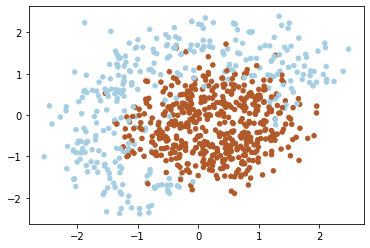

In [5]:
with open('train.npy', 'rb') as fin:
    X = np.load(fin)
    
with open('target.npy', 'rb') as fin:
    y = np.load(fin)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

# Task

## Features

As you can notice the data above isn't linearly separable. Since that we should add features (or use non-linear model). Note that decision line between two classes have form of circle, since that we can add quadratic features to make the problem linearly separable. The idea under this displayed on image below:

![](https://github.com/hse-aml/intro-to-dl/blob/master/week1/kernel.png?raw=1)

In [6]:
def expand(X):
    """
    Adds quadratic features. 
    This expansion allows your linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    X_expanded = np.zeros((X.shape[0], 6))
    X_expanded[:,0] = X[:,0]        # feature0
    X_expanded[:,1] = X[:,1]        # feature1
    X_expanded[:,2] = X[:,0]**2     # feature0^2
    X_expanded[:,3] = X[:,1]**2     # feature1^2
    X_expanded[:,4] = X[:,0]*X[:,1] # feature0*feature1
    X_expanded[:,5] = 1             # bias term
    return X_expanded

In [7]:
X_expanded = expand(X)

Here are some tests for your implementation of `expand` function.

In [8]:
# simple test on random numbers

dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

# call your expand function
dummy_expanded = expand(dummy_X)

# what it should have returned:   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])

#tests
assert isinstance(dummy_expanded,np.ndarray), "please make sure you return numpy array"
assert dummy_expanded.shape == dummy_expanded_ans.shape, "please make sure your shape is correct"
assert np.allclose(dummy_expanded,dummy_expanded_ans,1e-3), "Something's out of order with features"

print("Seems legit!")


Seems legit!


## Logistic regression

To classify objects we will obtain probability of object belongs to class '1'. To predict probability we will use output of linear model and logistic function:

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [9]:
#sigmoid helper function
def sigmoid(X):
   return 1/(1+np.exp(-X))

In [10]:
def probability(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above
        
    Don't forget to use expand(X) function (where necessary) in this and subsequent functions.
    
    :param X: feature matrix X of shape [n_samples,6] (expanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """
    return sigmoid(np.dot(X, w))

In [11]:
dummy_weights = np.linspace(-1, 1, 6)
ans_part1 = probability(X_expanded[:1, :], dummy_weights)[0]
ans_part1 # The probability is approximately 0.3804

0.3803998509843769

In [12]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("xU7U4", ans_part1)

In [13]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In logistic regression the optimal parameters $w$ are found by cross-entropy minimization:

Loss for one sample: $$ l(x_i, y_i, w) = - \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1\, | \, x_i,w))}\right] $$

Loss for many samples: $$ L(X, \vec{y}, w) =  {1 \over \ell} \sum_{i=1}^\ell l(x_i, y_i, w) $$



In [14]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] with values in {1, 0},
    and weight vector w [6], compute scalar loss function L using formula above.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    n_samples = X.shape[0] 
    p = probability(X, w)  # Shape: [n_samples,1]
    
    loss_sample = -(y*np.log(p) + (1-y)*np.log(1-p)) # Shape: [n_samples,1]
    loss = np.sum(loss_sample)/n_samples # Scalar loss value for all samples
    return loss

In [15]:
# use output of this cell to fill answer field 
ans_part2 = compute_loss(X_expanded, y, dummy_weights)
ans_part2 # The cross-entropy value is about 1.0185

1.0185634030782518

In [16]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("HyTF6", ans_part2)

In [17]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


Since we train our model with gradient descent, we should compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla_w L = {1 \over \ell} \sum_{i=1}^\ell \nabla_w l(x_i, y_i, w) $$ 

We won't be giving you the exact formula this time — instead, try figuring out a derivative with pen and paper. 

As usual, we've made a small test for you, but if you need more, feel free to check your math against finite differences (estimate how $L$ changes if you shift $w$ by $10^{-5}$ or so).

In [18]:
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    n_samples = X.shape[0]
    p = probability(X, w)
    dz = p - y                     # derivative of loss function w.r.t z 
    dw = np.dot(dz, X) / (n_samples)  # derivative of loss function w.r.t w
    return dw

In [19]:
# use output of this cell to fill answer field 
ans_part3 = np.linalg.norm(compute_grad(X_expanded, y, dummy_weights))
ans_part3 # The norm should be around 0.6402

0.6401687302118625

In [20]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("uNidL", ans_part3)

In [21]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


Here's an auxiliary function that visualizes the predictions:

In [22]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """draws classifier prediction with matplotlib magic"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

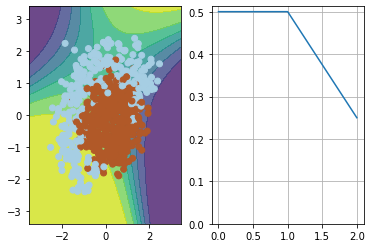

In [23]:
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

## Training
In this section we'll use the functions you wrote to train our classifier using stochastic gradient descent.

You can try changing hyperparameters like batch size, learning rate to optimize hyperparameters, but use our hyperparameters while submitting assignment.

## Mini-batch SGD

Stochastic gradient descent just takes a random batch of $m$ samples on each iteration, calculates a gradient of the loss on it and makes a step:
$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$



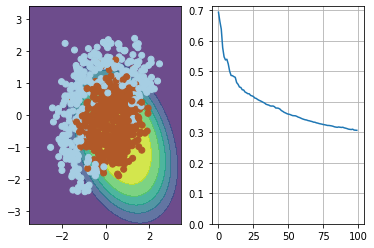

<Figure size 432x288 with 0 Axes>

In [24]:
# please use np.random.seed(42), eta=0.1, n_iter=100 and batch_size=4 for deterministic results

np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta= 0.1 # learning rate

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)

    # Keep in mind that compute_grad already does averaging over batch for you!
    w = w - eta * compute_grad(X_expanded[ind, :], y[ind], w)

visualize(X, y, w, loss)
plt.clf()

In [25]:
# use output of this cell to fill answer field 
ans_part4 = compute_loss(X_expanded, y, w)
ans_part4 # loss should be arround 0.304

0.3042764698992403

In [26]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("ToK7N", ans_part4)

In [27]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## SGD with momentum

Momentum is a method that helps accelerate SGD in the relevant direction and dampens oscillations as can be seen in image below. It does this by adding a fraction $\alpha$ of the update vector of the past time step to the current update vector.
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w l(x_{i_j}, y_{i_j}, w_t) $$
$$ w_t = w_{t-1} - \nu_t$$

<br>


![](https://github.com/hse-aml/intro-to-dl/blob/master/week1/sgd.png?raw=1)


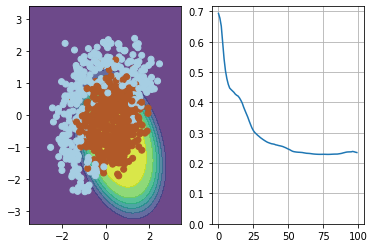

<Figure size 432x288 with 0 Axes>

In [28]:
# please use np.random.seed(42), eta=0.05, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05 # learning rate
alpha = 0.9 # momentum
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)
    nu = alpha*nu + eta*compute_grad(X_expanded[ind, :], y[ind], w)  # moment vector
    w = w - nu

visualize(X, y, w, loss)
plt.clf()

In [29]:
# use output of this cell to fill answer field 
ans_part5 = compute_loss(X_expanded, y, w)
ans_part5 # The loss with moment should be arround 0.232

0.23245916420113075

In [30]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("GBdgZ", ans_part5)

In [31]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## RMSprop

Implement RMSPROP algorithm, which use squared gradients to adjust learning rate:

$$ G_j^t = \alpha G_j^{t-1} + (1 - \alpha) g_{tj}^2 $$
$$ w_j^t = w_j^{t-1} - \dfrac{\eta}{\sqrt{G_j^t + \varepsilon}} g_{tj} $$

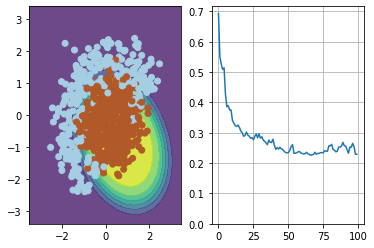

<Figure size 432x288 with 0 Axes>

In [32]:
# please use np.random.seed(42), eta=0.1, alpha=0.9, n_iter=100 and batch_size=4 for deterministic results
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1 # learning rate
alpha = 0.9 # moving average of gradient norm squared
G = np.zeros_like(w) 
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = np.random.choice(X_expanded.shape[0], batch_size)
    loss[i] = compute_loss(X_expanded, y, w)
    if i % 10 == 0:
        visualize(X_expanded[ind, :], y[ind], w, loss)
    
    dw = compute_grad(X_expanded[ind, :], y[ind], w)
    G = alpha*G + (1-alpha)*(dw**2)
    w = w - (eta/np.sqrt(G+eps))*dw
    
visualize(X, y, w, loss)
plt.clf()

In [33]:
# use output of this cell to fill answer field 
ans_part6 = compute_loss(X_expanded, y, w)
ans_part6 # Loss with RMSProp should be arround 0.223

0.22383829902910213

In [34]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("dLdHG", ans_part6)

In [35]:
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
